# Exploring the Weather Data Set of the Nairobi Ambulance Challenge <a name="Top"></a>
***
In this notebook we will look further into the Weather_Nairobi_Daily_GFS.csv data set.

## Table of Contents

[Imports and setup](#Imports_setup)<br>
[Extract, transform and load the data](#ETL)<br>
[Data cleaning](#Data_cleaning)<br>
[Feature engineering](#Feature_engineering)<br>
[Data analysis](#Data_analysis)<br>

</br>
</br>
</br>

***
## Imports and setup <a name="Imports_setup"></a>

### Importing packages

In [1]:
import pandas as pd
import datetime as dt
import holidays
import math
import matplotlib.pyplot as plt
import seaborn as sns

### Setup

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format

### Functions

In [3]:
def clean_weather_data(data):
    '''
    
    '''
    
    missing = data[pd.isnull(data).any(1)].index
    
    for col in data.columns[1:]:
        before = data.loc[missing[0]-1, col]
        after = data.loc[missing[-1]+1, col]
        diff = after - before
        for i in range(len(missing)):
            data.loc[missing[i], col] = before+diff/(len(missing)+1)*(i+1)
    return data



def clean_expand_train(df_train):
    '''
    
    '''
    
    df_train["date"] = df_train["datetime"].apply(lambda x: x.date())
    df_train["time"] = df_train["datetime"].apply(lambda x: x.time())
    df_train["day"] = df_train["datetime"].apply(lambda x: x.day)
    df_train["weekday"] = df_train["datetime"].apply(lambda x: x.weekday())
    df_train["weekend"] = df_train["weekday"].apply(lambda x: 1 if x>4 else 0)
    
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                   7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    df_train["month"] = df_train["datetime"].apply(lambda x: dict_months.get(x.month))
    df_train["year"] = df_train["datetime"].apply(lambda x: x.year)
    df_train["holiday"] = df_train["date"].apply(lambda x: 1 if (x in holidays.Kenya()) else 0)
    
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
    df_train["time_window"] = df_train["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df_train["time_window"] = df_train["time_window"].apply(lambda x: dict_windows.get(x))
    df_train["datetime_window"] = df_train[["date", "time_window"]].apply(lambda x : f"{x[0]}_{x[1]}", axis=1)
    
    return df_train



def create_time_windows(df_train):
    '''
    
    '''
    
    # Preparing df_train
    df_train["date"] = df_train["datetime"].apply(lambda x: x.date())
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
    df_train["time_window"] = df_train["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df_train["time_window"] = df_train["time_window"].apply(lambda x: dict_windows.get(x))
    df_train["datetime_window"] = df_train[["date", "time_window"]].apply(lambda x : f"{x[0]}_{x[1]}", axis=1)
    
    # Creating empty time windows
    date_list = pd.date_range(df_train["date"].min(), periods=546).tolist()
    window_list = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-24"]
    datetime_window_list = []
    for day in date_list:
        for time_window in window_list:
            datetime_window_list.append(str(day.date()) + "_" + time_window)
    
    # Creating dataframe from window_list
    df_complete = pd.DataFrame(datetime_window_list, columns=["datetime_window"])

    # Counting accidents per time window and leftjoin to complete dataframe
    acc_count = df_train.groupby("datetime_window").count()["uid"].reset_index()
    df_complete = df_complete.merge(acc_count[["datetime_window", "uid"]], on="datetime_window", how='left')
    df_complete.rename(columns={"uid":"accidents"}, inplace=True)
    
    # Creating new data frame with split value columns
    new = df_complete["datetime_window"].str.split("_", n=1, expand=True)
    
    # Adding date column to complete dataframe from new data frame
    df_complete["date"]= new[0].astype('datetime64[ns]')
    
    # Adding time_window column to complete dataframe from new data frame
    df_complete["time_window"]= new[1]
    
    # Adding day of month
    df_complete["day"] = df_complete["date"].apply(lambda x: x.day)
    
    # Adding weekday
    df_complete["weekday"] = df_complete["date"].apply(lambda x: x.weekday())
    
    # Adding 1 for weekend days and 0 for working days
    df_complete["weekend"] = df_complete["weekday"].apply(lambda x: 1 if x>4 else 0)
    
    # Adding month
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                   7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    df_complete["month"] = df_complete["date"].apply(lambda x: dict_months.get(x.month))
    
    # Adding year
    df_complete["year"] = df_complete["date"].apply(lambda x: x.year)
    
    # Adding holidays
    df_complete["holiday"] = df_complete["date"].apply(lambda x: 1 if (x in holidays.Kenya()) else 0)
    
    # Adding rainy / flood season (https://en.wikipedia.org/wiki/Nairobi#Climate)
    rainy_season = ["Mar", "Apr", "May", "Oct", "Nov", "Dec"]
    df_complete["rainy_season"] = df_complete["month"].apply(lambda x: 1 if (x in rainy_season) else 0)
    
    # Adding min for latitude and longitude
    l_min = df_train.groupby("datetime_window")[["latitude", "longitude"]].min().reset_index()
    df_complete = df_complete.merge(l_min[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
    df_complete.rename(columns={"latitude":"latitude_min", "longitude":"longitude_min"}, inplace=True)
    
    # Adding max for latitude and longitude
    l_max = df_train.groupby("datetime_window")[["latitude", "longitude"]].max().reset_index()
    df_complete = df_complete.merge(l_max[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
    df_complete.rename(columns={"latitude":"latitude_max", "longitude":"longitude_max"}, inplace=True)
    
    # Adding spread for latitude and longitude
    df_complete["latitude_spread"] = df_complete["latitude_max"] - df_complete["latitude_min"]
    df_complete["longitude_spread"] = df_complete["longitude_max"] - df_complete["longitude_min"]
    
    # Adding median for latitude and longitude
    l_median = df_train.groupby("datetime_window")[["latitude", "longitude"]].median().reset_index()
    df_complete = df_complete.merge(l_median[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
    df_complete.rename(columns={"latitude":"latitude_median", "longitude":"longitude_median"}, inplace=True)
    
    # Adding mean for latitude and longitude
    l_mean = df_train.groupby("datetime_window")[["latitude", "longitude"]].mean().reset_index()
    df_complete = df_complete.merge(l_mean[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
    df_complete.rename(columns={"latitude":"latitude_mean", "longitude":"longitude_mean"}, inplace=True)
    
    # Adding standard deviation for latitude and longitude
    l_std = df_train.groupby("datetime_window")[["latitude", "longitude"]].std().reset_index()
    df_complete = df_complete.merge(l_std[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
    df_complete.rename(columns={"latitude":"latitude_std", "longitude":"longitude_std"}, inplace=True)
    
    # Filling NaNs with zeros
    df_complete.fillna(value=0, inplace=True)
    
    # Changing type to integer
    df_complete["accidents"] = df_complete["accidents"].astype("int")
    
    return df_complete

[Back to top](#Top)<br>

</br>
</br>
</br>

## Extract, transform and load the data <a name="ETL"></a>

Importing the weather data.

In [4]:
df_weather = pd.read_csv('../Inputs/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
print(df_weather.shape)
df_weather.head()

(731, 7)


,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934
1,2018-01-02,27.362,74.900,0.010,16.048,0.315,-0.485
2,2018-01-03,30.247,86.600,0.012,15.839,-0.283,-0.654
3,2018-01-04,33.011,90.900,0.013,16.169,0.212,0.908
4,2018-01-05,27.250,82.413,0.011,15.923,1.047,-0.038


In [5]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  731 non-null    datetime64[ns]
 1   precipitable_water_entire_atmosphere  728 non-null    float64       
 2   relative_humidity_2m_above_ground     728 non-null    float64       
 3   specific_humidity_2m_above_ground     728 non-null    float64       
 4   temperature_2m_above_ground           728 non-null    float64       
 5   u_component_of_wind_10m_above_ground  728 non-null    float64       
 6   v_component_of_wind_10m_above_ground  728 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 40.1 KB


In [6]:
df_weather.describe().T

,count,mean,std,min,25%,50%,75%,max
precipitable_water_entire_atmosphere,728.000,23.977,4.693,10.800,20.700,24.025,27.500,34.000
relative_humidity_2m_above_ground,728.000,83.160,9.085,42.200,79.888,85.627,89.600,95.769
specific_humidity_2m_above_ground,728.000,0.011,0.001,0.006,0.010,0.011,0.012,0.013
temperature_2m_above_ground,728.000,15.176,1.127,11.750,14.431,15.231,15.916,19.928
u_component_of_wind_10m_above_ground,728.000,-1.907,1.251,-5.880,-2.736,-1.953,-1.168,3.478
v_component_of_wind_10m_above_ground,728.000,-1.128,1.119,-3.797,-1.979,-1.084,-0.274,1.973


Importing the accident data from train.csv

In [7]:
df_train = pd.read_csv('../Inputs/Train.csv', parse_dates=['datetime'])
print(df_train.shape)
df_train.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.189,36.931
1,2,2018-01-01 02:02:39,-0.663,37.209
2,3,2018-01-01 02:31:49,-0.663,37.209
3,4,2018-01-01 03:04:01,-1.288,36.827
4,5,2018-01-01 03:58:49,-1.189,36.931


[Back to top](#Top)<br>

</br>
</br>
</br>

## Data cleaning <a name="Data_cleaning"></a>

In [8]:
missing_bool = pd.isnull(df_weather).any(1)
df_weather[missing_bool]

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
74,2018-03-16,nan,nan,nan,nan,nan,nan
75,2018-03-17,nan,nan,nan,nan,nan,nan
76,2018-03-18,nan,nan,nan,nan,nan,nan


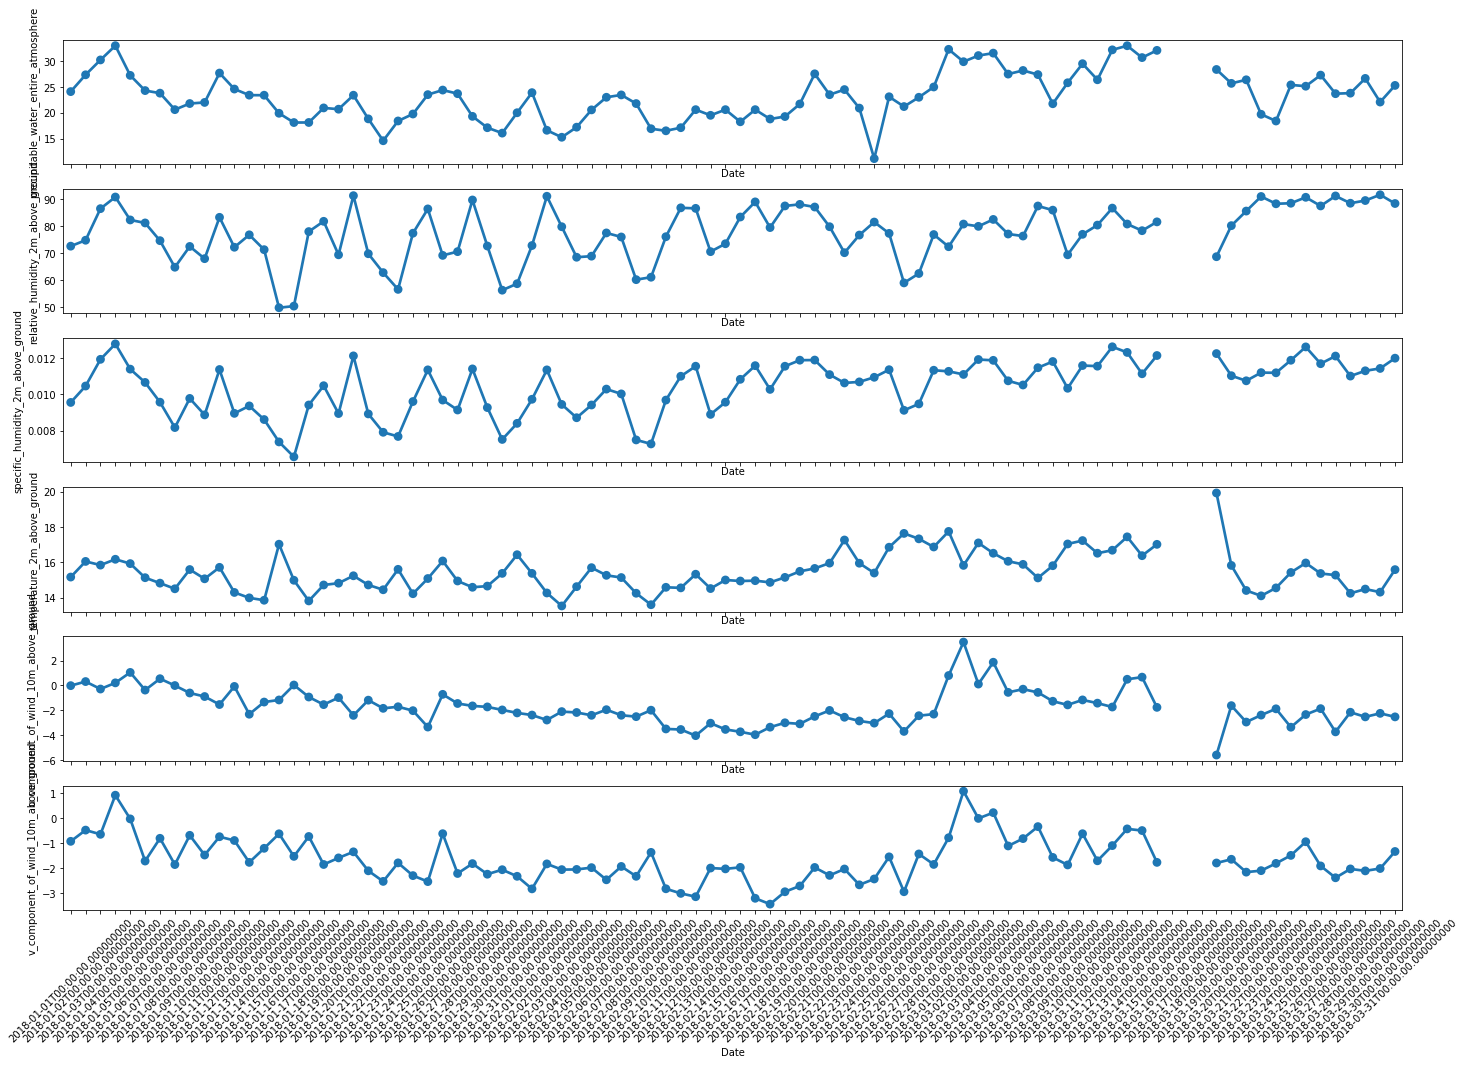

In [9]:
quarter = df_weather[(df_weather["Date"] >= "2018-01-01") & (df_weather["Date"] <= "2018-03-31")]

fig, ax = plt.subplots(6, 1, sharex=True, figsize=(24, 16))
for col in range(len(quarter.columns)-1):
    chart = sns.pointplot(ax=ax[col], x=quarter["Date"], y=quarter[quarter.columns[col+1]]);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [10]:
df_weather = clean_weather_data(df_weather)

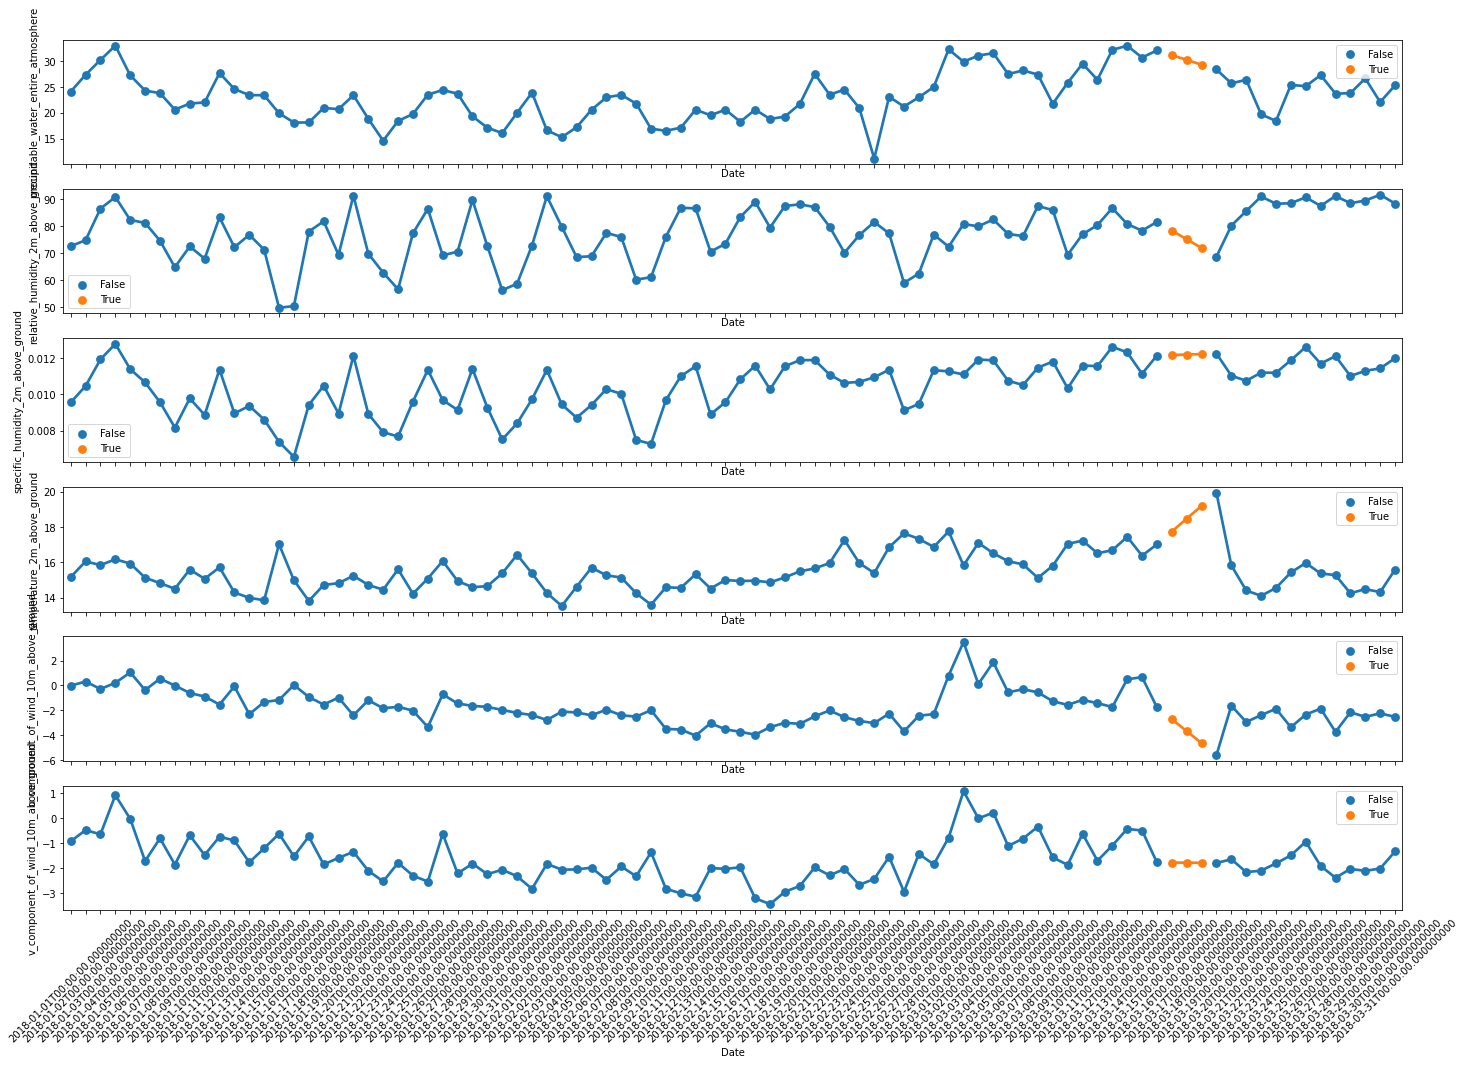

In [11]:
quarter = df_weather[(df_weather["Date"] >= "2018-01-01") & (df_weather["Date"] <= "2018-03-31")]

fig, ax = plt.subplots(6, 1, sharex=True, figsize=(24, 16))
for col in range(len(quarter.columns)-1):
    chart = sns.pointplot(ax=ax[col], x=quarter["Date"], y=quarter[quarter.columns[col+1]], hue=missing_bool);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

[Back to top](#Top)<br>

</br>
</br>
</br>

## Feature engineering <a name="Feature_engineering"></a>

Joining the weather data to the accident data on date column.

In [12]:
def add_weather_change(df_weather):
    df_weather["change_water_atmosphere"] = 0
    df_weather["change_temperature"] = 0
    for row in range(df_weather.shape[0]):
        if row == 0:
            df_weather.loc[row, "change_water_atmosphere"] = 0
            df_weather.loc[row, "change_temperature"] = 0
        else:
            df_weather.loc[row, "change_water_atmosphere"] = df_weather.loc[row, "precipitable_water_entire_atmosphere"] - df_weather.loc[row-1, "precipitable_water_entire_atmosphere"]
            df_weather.loc[row, "change_temperature"] = df_weather.loc[row, "temperature_2m_above_ground"] - df_weather.loc[row-1, "temperature_2m_above_ground"]
    return df_weather

In [13]:
df_train["date"] = df_train["datetime"].apply(lambda x: x.date())
df_weather["Date"] = df_weather["Date"].apply(lambda x: x.date())

df_weather = add_weather_change(df_weather)

df_train = df_train.merge(df_weather, left_on="date", right_on="Date", how="left")
df_train = df_train.drop("Date", axis=1)

df_train.head()

,uid,datetime,latitude,longitude,date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,change_water_atmosphere,change_temperature
0,1,2018-01-01 00:25:46,-1.189,36.931,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
1,2,2018-01-01 02:02:39,-0.663,37.209,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
2,3,2018-01-01 02:31:49,-0.663,37.209,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
3,4,2018-01-01 03:04:01,-1.288,36.827,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
4,5,2018-01-01 03:58:49,-1.189,36.931,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000


Joining the weather data to the complete time window data with aggregated accidents.

In [14]:
df_train_complete = create_time_windows(df_train)
df_train_complete["date"] = df_train_complete["date"].apply(lambda x: x.date())

df_train_complete = df_train_complete.merge(df_weather, left_on="date", right_on="Date", how="left")
df_train_complete = df_train_complete.drop("Date", axis=1)

df_train_complete.head()

,datetime_window,accidents,date,time_window,day,weekday,weekend,month,year,holiday,rainy_season,latitude_min,longitude_min,latitude_max,longitude_max,latitude_spread,longitude_spread,latitude_median,longitude_median,latitude_mean,longitude_mean,latitude_std,longitude_std,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,change_water_atmosphere,change_temperature
0,2018-01-01_00-03,3,2018-01-01,00-03,1,0,0,Jan,2018,1,0,-1.189,36.931,-0.663,37.209,0.526,0.277,-0.663,37.209,-0.838,37.116,0.304,0.160,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
1,2018-01-01_03-06,4,2018-01-01,03-06,1,0,0,Jan,2018,1,0,-1.288,36.827,-0.663,37.209,0.625,0.382,-1.177,36.946,-1.076,36.982,0.281,0.162,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
2,2018-01-01_06-09,1,2018-01-01,06-09,1,0,0,Jan,2018,1,0,-1.301,36.821,-1.301,36.821,0.000,0.000,-1.301,36.821,-1.301,36.821,0.000,0.000,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
3,2018-01-01_09-12,4,2018-01-01,09-12,1,0,0,Jan,2018,1,0,-1.283,36.827,-1.117,37.008,0.165,0.181,-1.203,36.838,-1.202,36.878,0.088,0.087,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
4,2018-01-01_12-15,1,2018-01-01,12-15,1,0,0,Jan,2018,1,0,-1.605,37.167,-1.605,37.167,0.000,0.000,-1.605,37.167,-1.605,37.167,0.000,0.000,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000


[Back to top](#Top)<br>

</br>
</br>
</br>

## Data analysis <a name="Data_analysis"></a>

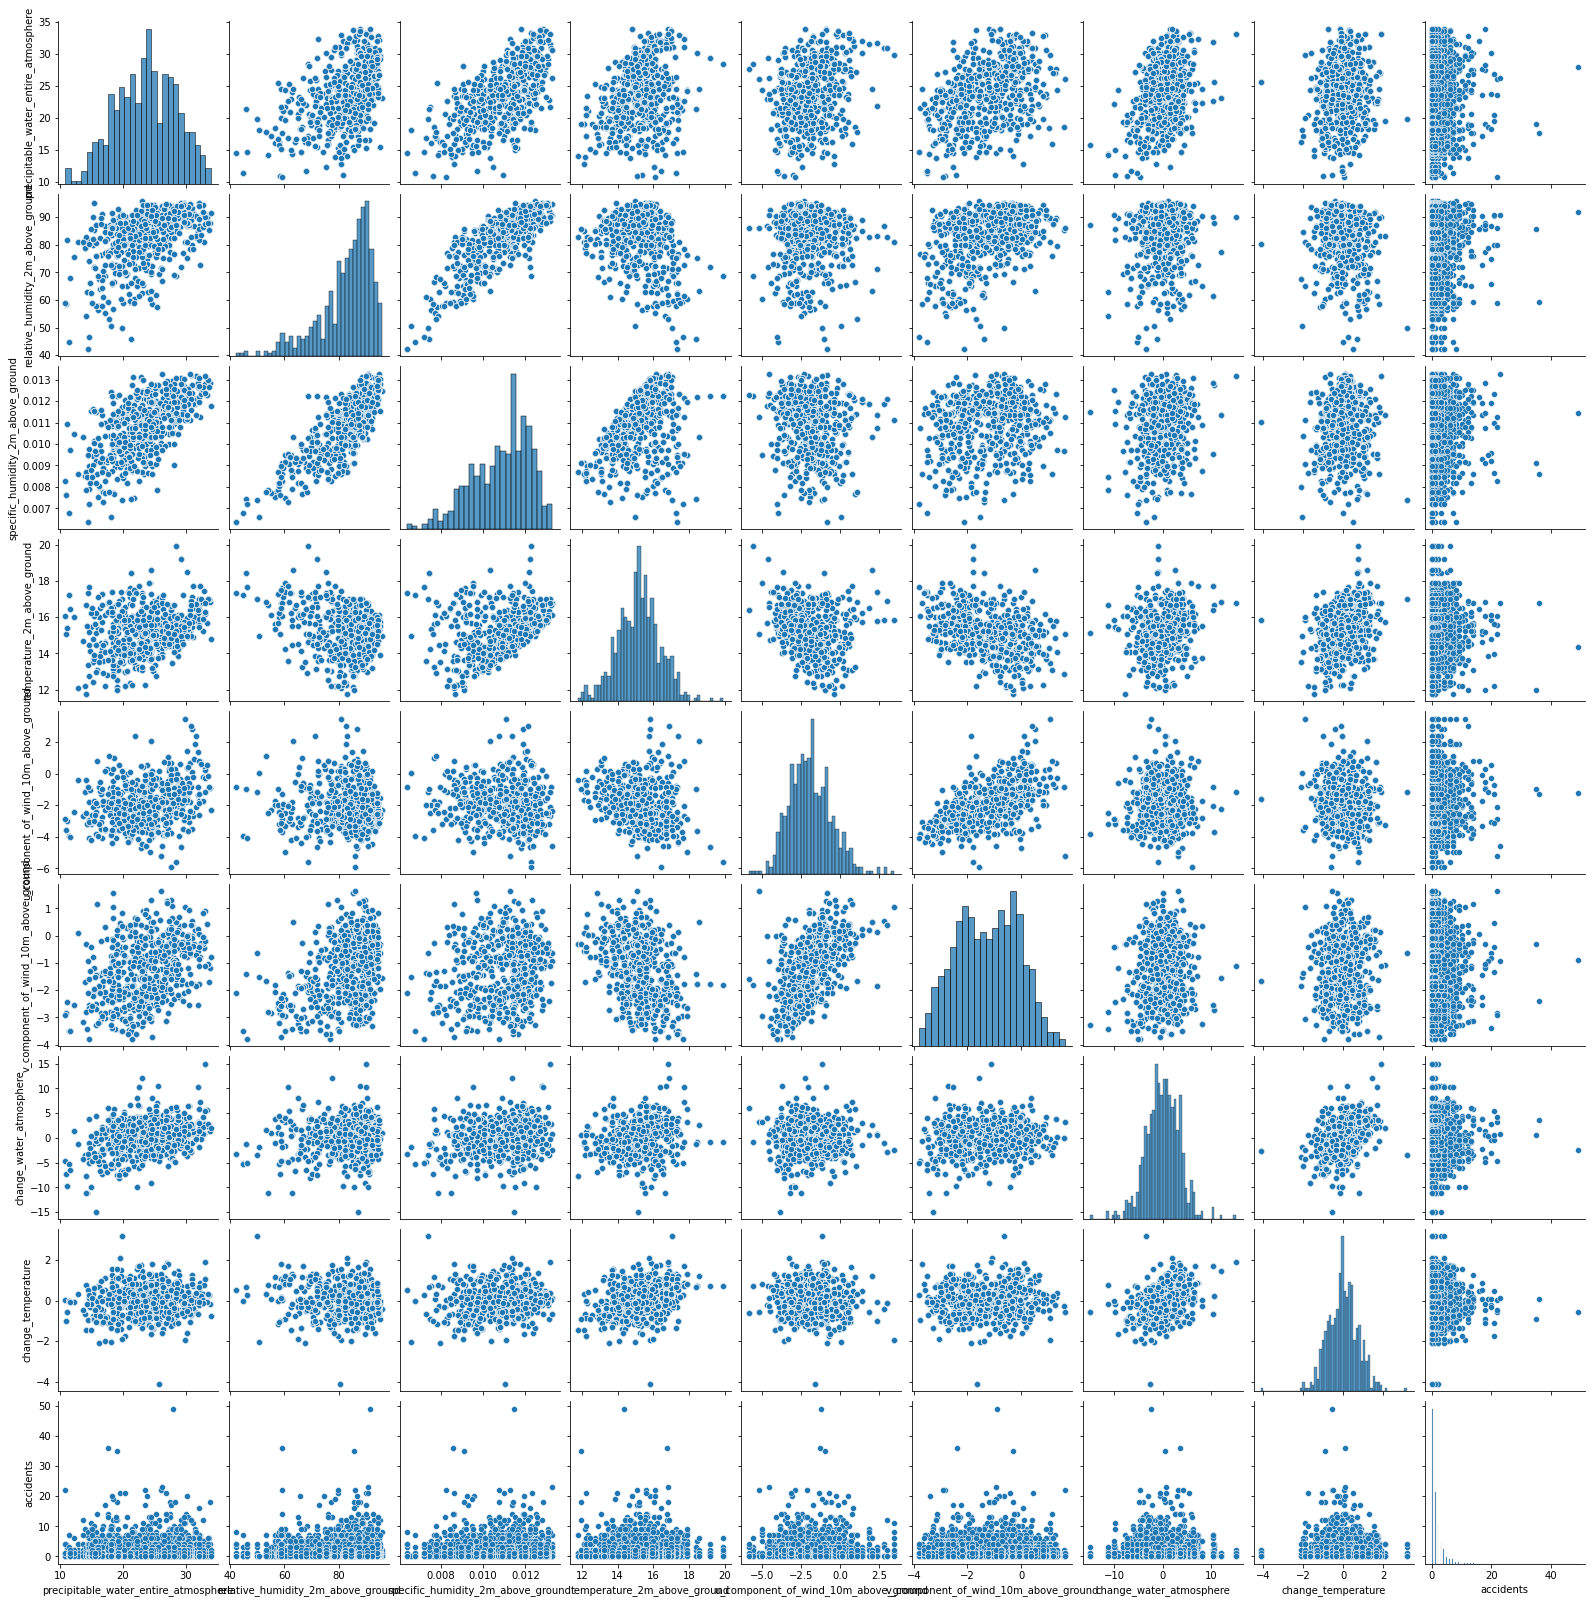

In [15]:
weather_accidents = df_train_complete[["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground",
                                       "specific_humidity_2m_above_ground", "temperature_2m_above_ground",
                                       "u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground",
                                       "change_water_atmosphere", "change_temperature", "accidents"]]
chart = sns.pairplot(weather_accidents);

In [16]:
weather_accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4368 entries, 0 to 4367
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   precipitable_water_entire_atmosphere  4368 non-null   float64
 1   relative_humidity_2m_above_ground     4368 non-null   float64
 2   specific_humidity_2m_above_ground     4368 non-null   float64
 3   temperature_2m_above_ground           4368 non-null   float64
 4   u_component_of_wind_10m_above_ground  4368 non-null   float64
 5   v_component_of_wind_10m_above_ground  4368 non-null   float64
 6   change_water_atmosphere               4368 non-null   float64
 7   change_temperature                    4368 non-null   float64
 8   accidents                             4368 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 341.2 KB


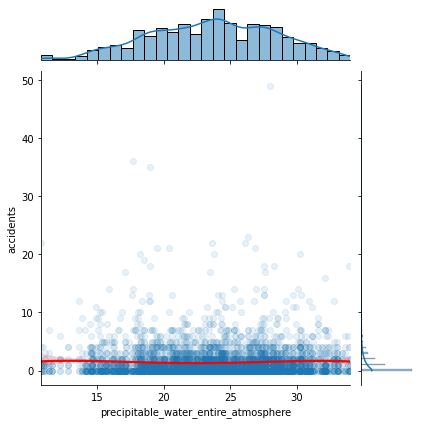

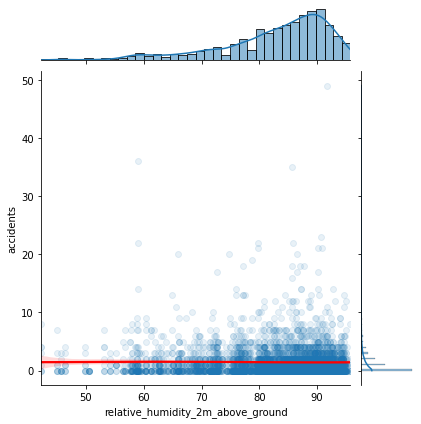

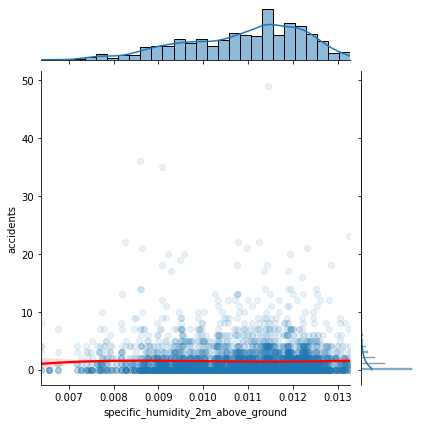

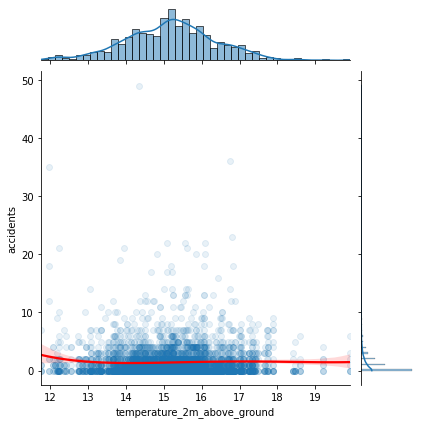

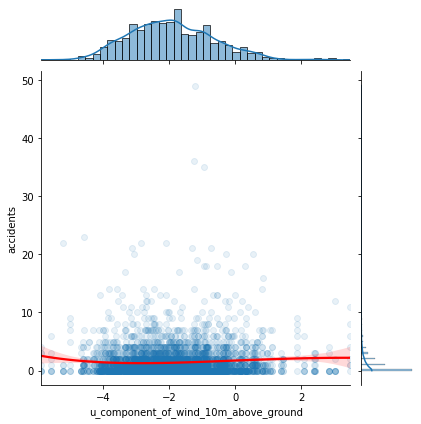

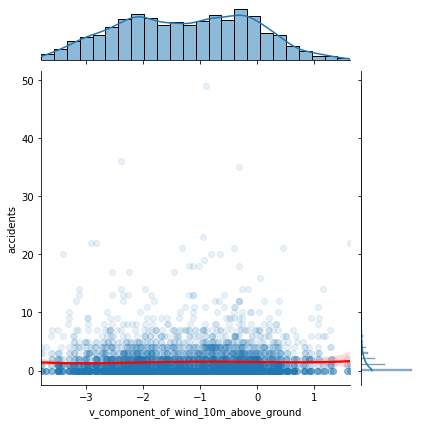

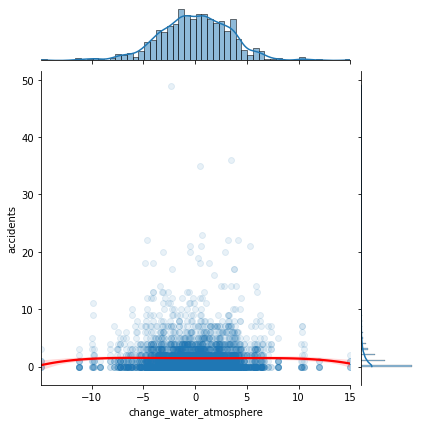

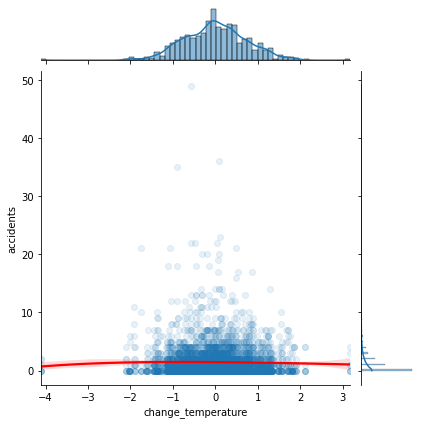

In [20]:
for col in weather_accidents.columns[:-1]:
    sns.jointplot(x=weather_accidents[col], y=weather_accidents["accidents"], kind="reg", order=4,
                  joint_kws={"line_kws":{"color":"r"}, "scatter_kws":{"alpha":0.1}});

* scale data
* external data
* distribute over day

[Back to top](#Top)<br>